<a href="https://colab.research.google.com/github/ricardodeazambuja/License-Plate-Detection-for-Embedded-Systems/blob/master/ANPR_ALPR_license_detector_using_MobileNetV2_SSDlite_frozen_model_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ricardodeazambuja/License-Plate-Detection-for-Embedded-Systems.git

Cloning into 'License-Plate-Detection-for-Embedded-Systems'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 84 (delta 33), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [2]:
cd License-Plate-Detection-for-Embedded-Systems/

/content/License-Plate-Detection-for-Embedded-Systems


In [3]:
ls detection/model/ 

frozen_inference_graph.pb


In [4]:
cat detection/protos/lp_label_map.pbtxt

item {
  id: 1
  name: 'lp'
}

In [ ]:
# %%file /content/License-Plate-Detection-for-Embedded-Systems/detection/lpDetector.py
# import os
# import numpy as np
# # import tensorflow as tf
# import tensorflow.compat.v1 as tf

# BASE_DIR = os.path.dirname(__file__) + '/'

# PATH_TO_CKPT = 'model/frozen_inference_graph.pb'
# PATH_TO_LABELS = 'protos/lp_label_map.pbtxt'


# class lpDetector:
#     def __init__(self):        
#         self.detection_graph = tf.Graph()
#         self.sess = tf.Session(graph=self.detection_graph)
#         with self.detection_graph.as_default():
#             od_graph_def = tf.GraphDef()
#             with tf.gfile.GFile(BASE_DIR + PATH_TO_CKPT, 'rb') as fid:
#                 serialized_graph = fid.read()
#                 od_graph_def.ParseFromString(serialized_graph)
#                 tf.import_graph_def(od_graph_def, name='')

#         self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')        
#         self.boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')        
#         self.scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
#         self.classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
#         self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

#     def __del__(self):
#         self.sess.close()

#     def detect(self, image):
        
#         image_expanded = np.expand_dims(image, axis=0)
        
#         (boxes, scores, classes, num_detections) = self.sess.run(
#             [self.boxes, self.scores, self.classes, self.num_detections],
#             feed_dict={self.image_tensor: image_expanded})
        
#         boxes[0, :, [0, 2]] = (boxes[0, :, [0, 2]]*image.shape[0])
#         boxes[0, :, [1, 3]] = (boxes[0, :, [1, 3]]*image.shape[1])
#         return np.squeeze(boxes).astype(int), np.squeeze(scores), classes

Overwriting /content/License-Plate-Detection-for-Embedded-Systems/detection/lpDetector.py


In [5]:
from PIL import Image, ImageDraw
import numpy as np

from detection.lpDetector import lpDetector

lp_detector = lpDetector()

def detect_plate(image_path):
  image = Image.open(image_path)
  image = image.convert('RGB')

  height, width = image.size
  print("image file:", image_path, "(%dx%d)" % (width, height))

  frame = np.asarray(image)
  frame = frame[:, :, 0:3]
  (boxes, scores, classes) = lp_detector.detect(frame)
  vl_boxes = boxes[np.argwhere(scores>0.3).reshape(-1)]
  vl_scores = scores[np.argwhere(scores>0.3).reshape(-1)]
    
  draw = ImageDraw.Draw(image)
  if len(vl_boxes) > 0:
      for i in range(len(vl_boxes)):
          box = vl_boxes[i]
          # cropped_vl = frame[box[0]:box[2], box[1]:box[3], :]
          # cv2.rectangle(frame, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)
          draw.rectangle([(int(box[1]), int(box[0])), (int(box[3]), int(box[2]))], width=3, outline='red')
  else:
      print('Unable to align')
  
  return image

In [6]:
!wget https://stage-drupal.car.co.uk/s3fs-public/styles/original_size/public/2019-09/why-are-number-plates-yellow-and-white.jpg -O car_with_plate.jpg
# !wget https://i.pinimg.com/originals/b3/c9/5e/b3c95e698e61c2d7ac9b076f61194fcc.jpg -O car_with_plate.jpg
# !wget https://www.menswearstyle.co.uk/content/blogs/2c23c162-3858-4d36-a38f-632b6a09dc40_blog_ln_.jpg -O car_with_plate.jpg

--2021-05-06 12:56:09--  https://stage-drupal.car.co.uk/s3fs-public/styles/original_size/public/2019-09/why-are-number-plates-yellow-and-white.jpg
Resolving stage-drupal.car.co.uk (stage-drupal.car.co.uk)... 13.32.240.54, 13.32.240.35, 13.32.240.63, ...
Connecting to stage-drupal.car.co.uk (stage-drupal.car.co.uk)|13.32.240.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167246 (163K) [image/jpeg]
Saving to: ‘car_with_plate.jpg’

car_with_plate.jpg  100%[===================>] 163.33K  --.-KB/s    in 0.08s   

2021-05-06 12:56:10 (1.99 MB/s) - ‘car_with_plate.jpg’ saved [167246/167246]



image file: car_with_plate.jpg (742x1200)


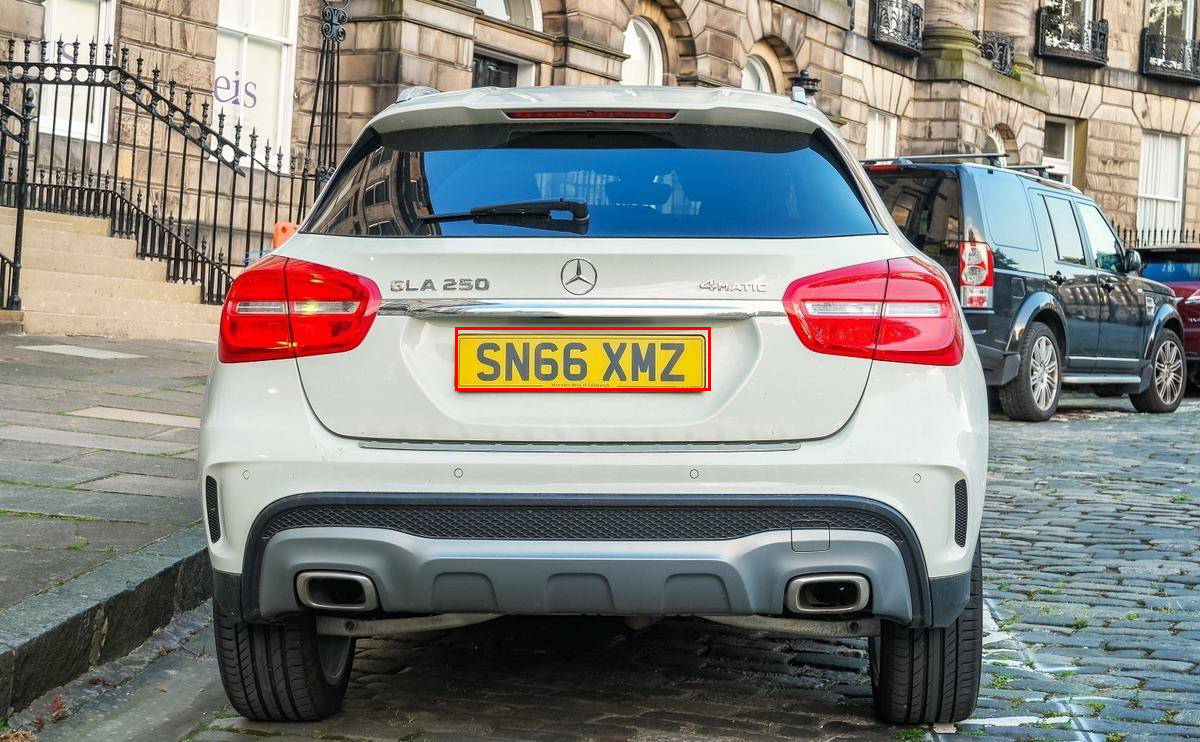

In [7]:
detect_plate("car_with_plate.jpg")

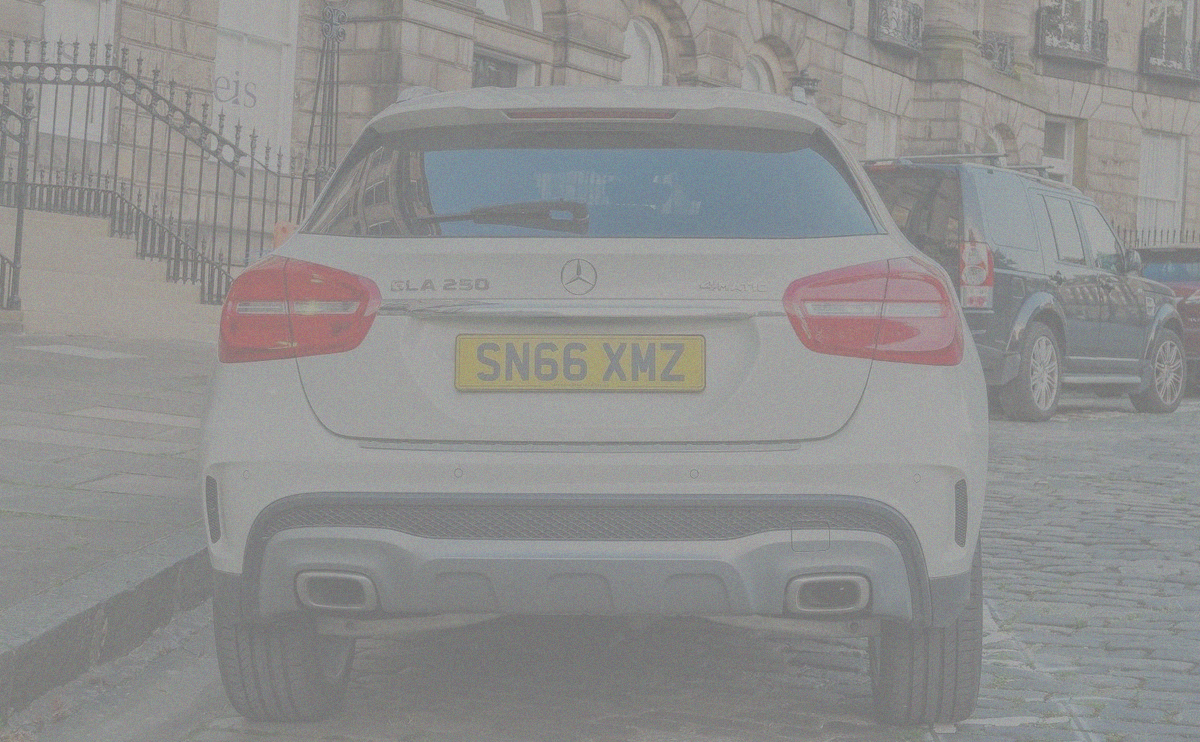

In [8]:
from PIL import ImageEnhance
# https://medium.com/swlh/image-enhance-recipes-in-pillow-67bf39b63bd
# https://pillow.readthedocs.io/en/3.0.x/reference/ImageEnhance.html

factor = 0.2

im = Image.open("car_with_plate.jpg")
# im_out = ImageEnhance.Sharpness(im).enhance(factor)
# im_out = ImageEnhance.Color(im).enhance(factor)
# im_out = ImageEnhance.Brightness(im).enhance(factor)
im_out = ImageEnhance.Contrast(im).enhance(factor)

# add some noise
im_out = Image.fromarray(np.asarray(im_out)+(np.random.rand(im_out.size[1],im_out.size[0],3)*20).astype('uint8'))

im_out.save("car_with_plate_modified.jpg")
im_out

image file: car_with_plate_modified.jpg (742x1200)


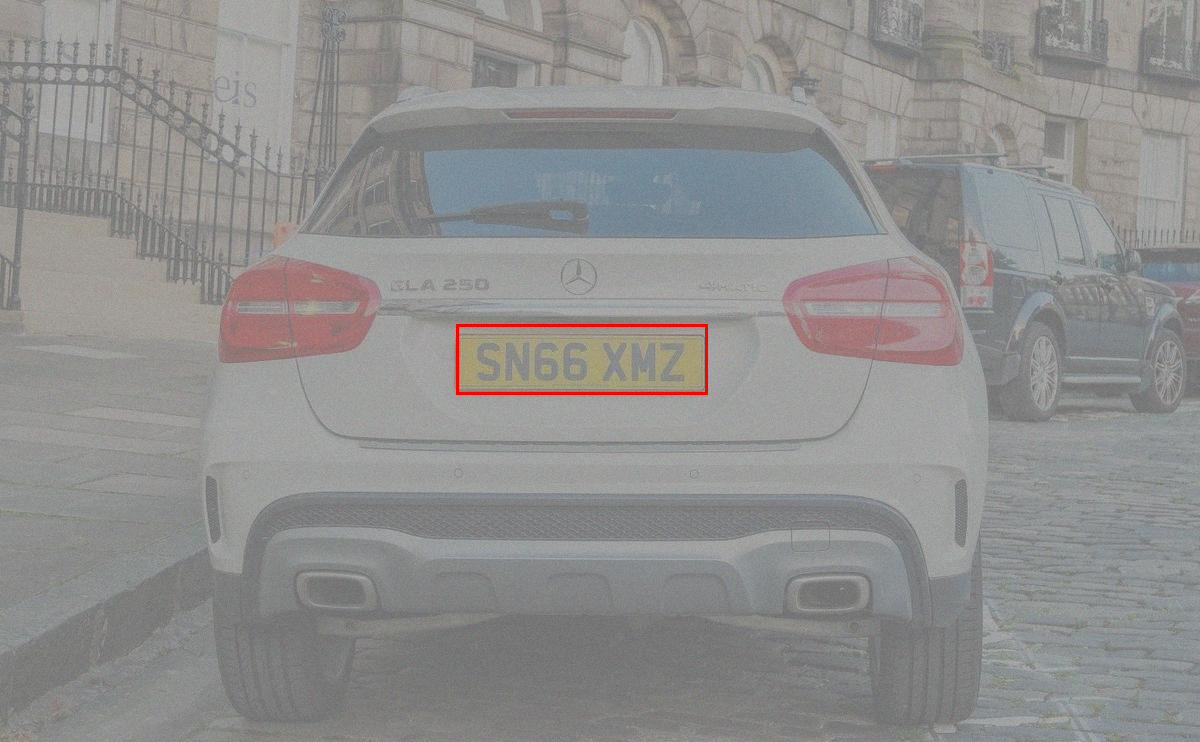

In [9]:
detect_plate("car_with_plate_modified.jpg")